In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [3]:
#url = "https://www.quandl.com/api/v3/datasets/WIKI/AAPL.csv"
df = pd.read_csv('HistoricalQuotes.csv')
print('First three rows:')
print(df.head(3))
print('\nLast three rows:')
print(df.tail(3))

First three rows:
         date   close         volume    open      high     low
0       16:00  176.69     41,297,668  181.00  182.3899  176.27
1  2018/12/03  184.82  40537700.0000  184.46  184.9400  181.21
2  2018/11/30  178.58  39424260.0000  180.29  180.3300  177.03

Last three rows:
            date    close          volume     open     high      low
2516  2008/12/05  13.4286  260894768.0000  12.9071  13.4986  12.6943
2517  2008/12/04  13.0586  272823192.0000  13.4900  13.6014  12.7229
2518  2008/12/03  13.7000  334651410.0000  12.7714  13.7471  12.6857


In [4]:
dfnew = df
#1. Remove the first row
dfnew = dfnew.drop(0,axis = 0) 
#2. Keep only date and volume columns
dfnew = dfnew[['date','volume']]
#3. Reverse the order of date column
dfnew.date = pd.to_datetime(dfnew.date, format = '%Y/%m/%d')
dfnew.volume = pd.to_numeric(dfnew.volume)
dfnew = dfnew.sort_values('date',ascending = True).set_index('date')

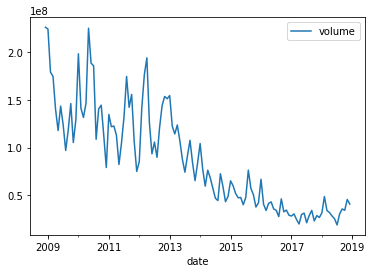

In [5]:
monthly_volume_sample = dfnew.resample('M')
avg_monthly_vol = monthly_volume_sample.sum()/monthly_volume_sample.count()
avg_monthly_vol.plot()
plt.show()

# Test and Training Sets
The monthly data has 121 measurements. Last 6 (ntest) months of observations will be good for test set and 115 months of
data will be used as a training set.

In [6]:
ntest = 6 # Size of test sets
train_set  = avg_monthly_vol.iloc[:-ntest]
test_set = avg_monthly_vol[-ntest:]

# Supervised Univariate Time Series
We have to test how many time series values in the past affect the current value. 
One way to check is autocorrelation function as done for ARIMA models.

In [7]:
#from statsmodels.graphics.tsaplots import plot_acf
#plot_acf(train_set, lags = 25)
#plt.show()

ModuleNotFoundError: No module named 'statsmodels'

Based on the above plot lag of 9 months is statistically significant in relation to value at any point.

In [12]:
# evaluate mlp
from math import sqrt
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
import matplotlib.pyplot as plt
import tensorflow
 
# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
    return data[:-n_test], data[-n_test:]
 
# transform list into supervised learning format
def series_to_supervised(data, n_in=1, n_out=1):
    df = pd.DataFrame(data)
    cols = list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
    # put it all together
    agg = pd.concat(cols, axis=1)
    # drop rows with NaN values
    agg.dropna(inplace=True)
    return agg.values
 
# root mean squared error or rmse
def measure_rmse(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))
 
# fit a model
def model_fit(train, config):
    # unpack config
    n_input, n_nodes, n_epochs, n_batch = config
    # prepare data
    data = series_to_supervised(train, n_in=n_input)
    train_x, train_y = data[:, :-1], data[:, -1]
    # define model
    model = Sequential()
    model.add(Dense(n_nodes, activation='relu', input_dim=n_input))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    # fit
    model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch, verbose=0)
    return model
 
# forecast with a pre-fit model
def model_predict(model, history, config):
    # unpack config
    n_input, _, _, _ = config
    # prepare data
    x_input = array(history[-n_input:]).reshape(1, n_input)
    # forecast
    yhat = model.predict(x_input, verbose=0)
    return yhat[0]
 
# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
    predictions = list()
    # split dataset
    train, test = train_test_split(data, n_test)
    # fit model
    model = model_fit(train, cfg)
    # seed history with training dataset
    history = [x for x in train]
    # step over each time-step in the test set
    for i in range(len(test)):
        # fit model and make forecast for history
        yhat = model_predict(model, history, cfg)
        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history.append(test[i])
    # estimate prediction error
    error = measure_rmse(test, predictions)
    print(' > %.3f' % error)
    return error
 
# repeat evaluation of a config
def repeat_evaluate(data, config, n_test, n_repeats=30):
    # fit and evaluate the model n times
    scores = [walk_forward_validation(data, n_test, config) for _ in range(n_repeats)]
    return scores
 
# summarize model performance
def summarize_scores(name, scores):
    # print a summary
    scores_m, score_std = mean(scores), std(scores)
    print('%s: %.3f RMSE (+/- %.3f)' % (name, scores_m, score_std))
    # box and whisker plot
    pyplot.boxplot(scores)
    
    pyplot.show()
 



In [1]:
data = avg_monthly_vol.values
# data split
n_test = 6
# define config
config = [9, 500, 100, 100]
# grid search
scores = repeat_evaluate(data, config, n_test)
# summarize scores
summarize_scores('mlp', scores)

NameError: name 'avg_monthly_vol' is not defined